# Iron March Anonymous Wikipedia Edits

This notebook briefly examines how to examine whether IP addresses associated with the fascist Iron March forum had edited Wikipedia anonymously. These IP addresses were part of a dataset that was [leaked](https://www.bellingcat.com/resources/how-tos/2019/11/06/massive-white-supremacist-message-board-leak-how-to-access-and-interpret-the-data/). The idea to do this was suggested by [@z3dster](https://twitter.com/z3dster/status/1193930176863883264) on Twitter.

## IP Addresses

First lets load in all the IP address from the torrent dataset. You'll need to obtain the dataset yourself, it's nt included as part of this notebook repository. Once you have it update the path appropriately. We're going to keep track of the date that the account was created because IP addresses from ISPs can change all the time.

As the Bellingcat article points out the IP addresses need to be taken with a huge grain of salt, because users could be behind proxies or VPNs, and the ISP for your IP address changes all the time. Presenting the edit with a WHOIS lookup for the IP address helps in evaluating the data. But it must be stressed that this is far from certain.

When we look up edits in Wikipedia we could assume that the IP address was recorded when the account was created. But this is a big assumption because the IP address could be updated with every login, depending on how the Iron March platform operated. Looking at the leaked database it appears that the forum might have been hosted using [Invision Community](https://en.wikipedia.org/wiki/Invision_Community). But this is proprietary (closed source) so it's difficult to say how the IP address was recorded.

In [111]:
import os
import pandas

data_dir = '/Users/edsu/Downloads/iron_march_201911/'

users = pandas.read_csv(os.path.join(data_dir, 'csv/core_members.csv'), parse_dates=['joined'])
users.head()


,member_id,name,member_group_id,email,joined,ip_address,allow_admin_mails,skin,warn_level,warn_lastwarn,...,member_title,member_posts,member_last_post,member_streams,photo_last_update,pp_setting_count_visitors,pp_xbox,failed_mfa_attempts,mfa_details,permission_array
0,1,Александр Славрос,4,slavros_a@mail.ru,1315842419,178.140.119.217,\0,0.0,0.0,0,...,Crablord,7715,1.511213e+09,NaN,1.505261e+09,0,NaN,0,NaN,NaN
1,2,PhalNat,13,illuminatienlightened@hotmail.com,1315842750,68.37.21.125,,0.0,0.0,0,...,THE HATE BUS,1262,1.443205e+09,NaN,NaN,0,NaN,0,NaN,NaN
2,3,Blood and Iron,13,renegader23@aim.com,1315851011,68.10.255.89,,0.0,0.0,0,...,14/88 Bread on the Floor,490,1.495587e+09,NaN,NaN,0,NaN,0,NaN,NaN
3,4,Mierce,13,hominemcura@gmail.com,1315859255,82.29.169.221,\0,0.0,0.0,0,...,Multiracial Mierda,1719,1.488210e+09,NaN,NaN,0,NaN,0,NaN,NaN
4,5,Will to Power,14,tashkentfox@hotmail.com,1315861097,90.214.150.70,,0.0,0.0,0,...,A fox,459,1.327590e+09,NaN,NaN,0,NaN,0,NaN,NaN


It's interesting to quickly see the growth of users over time. To do that lets convert the epoch time in the joined column to a proper datetime.

In [182]:
users['joined'] = pandas.to_datetime(users['joined'], unit='s')

In [183]:
joined = users.resample('M', on='joined').count().member_id
joined = joined.reset_index()
joined.columns = ['joined', 'users']
joined.head()

,joined,users
0,2011-09-30,23
1,2011-10-31,9
2,2011-11-30,3
3,2011-12-31,5
4,2012-01-31,6


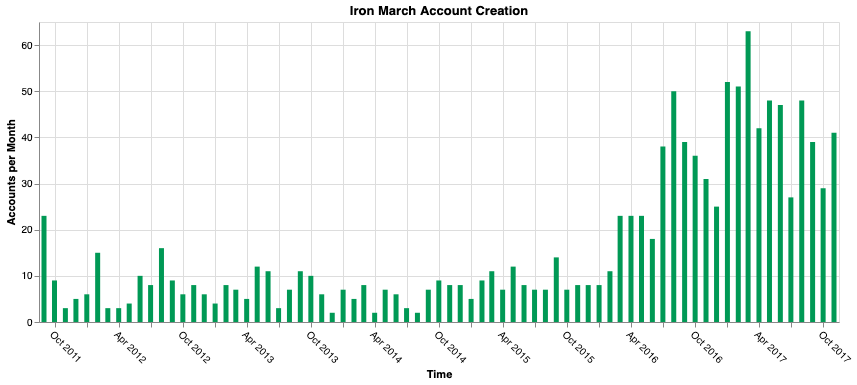

In [184]:
import altair

altair.renderers.enable('notebook')

chart = altair.Chart(joined, width=800, title="Iron March Account Creation")
chart = chart.configure_axisX(labelAngle=45)

chart = chart.mark_bar().encode(
    altair.X('yearmonth(joined):T', title="Time"),
    altair.Y('users', title="Accounts per Month"),
)

chart = chart.configure_mark(color='#095')

chart

So it was clearly in a growth phase when it was shut down. And perhaps it's just a coincidence, but growth seems to have accelerated during the 2016 presidential election...

## Wikipedia Edits

Now lets create a function that uses Wikipedia's [XTools](https://xtools.wmflabs.org/) service, specifically its [API](https://xtools.readthedocs.io/en/stable/api/), to return the page edits for a given IP address for a particular wikipedia site (e.g. *en.wikipedia.org* for a particular date range (which defaults to the last year).

In [132]:
import datetime
import requests

def get_edits(ip, wikipedia="en.wikipedia.org", start=None, end=None):
    if start is None and end is None:
        end = datetime.date.today()
        start = end - datetime.timedelta(days=365)
        
    url = 'https://xtools.wmflabs.org/api/user/nonautomated_edits/{}/{}/all/{}/{}'.format(
        wikipedia,
        ip,
        start.strftime('%Y-%m-%d'),
        end.strftime('%Y-%m-%d')
    )
    results = requests.get(url).json()
    return results['nonautomated_edits']
    

Now we can test the function out on an IP address for the US House of Representatives [143.231.249.135](https://en.wikipedia.org/wiki/Special:Contributions/143.231.249.135).

In [133]:
get_edits('143.231.249.135')

[{'full_page_title': 'Karen_Bass',
  'page_title': 'Karen_Bass',
  'page_namespace': 0,
  'rev_id': 925252700,
  'timestamp': 20191108211033,
  'minor': 0,
  'length': 42636,
  'length_change': 10639,
  'comment': 'Updated the Political Positions section to make it more current and accurate.'},
 {'full_page_title': 'Karen_Bass',
  'page_title': 'Karen_Bass',
  'page_namespace': 0,
  'rev_id': 925247589,
  'timestamp': 20191108203053,
  'minor': 0,
  'length': 31997,
  'length_change': 2710,
  'comment': 'Updated the California Assembly section to be more accurate.'},
 {'full_page_title': 'Karen_Bass',
  'page_title': 'Karen_Bass',
  'page_namespace': 0,
  'rev_id': 925246118,
  'timestamp': 20191108201930,
  'minor': 0,
  'length': 29287,
  'length_change': 2601,
  'comment': 'Updating the early life and education to make it more current and more accurate.'},
 {'full_page_title': 'Karen_Bass',
  'page_title': 'Karen_Bass',
  'page_namespace': 0,
  'rev_id': 925239688,
  'timestamp': 20

## Whois

It might be useful to get a sense of where IP addresses are coming from, since they can change a lot depending on the ISP, or whether the IP is behind an organizational proxy.

In [178]:
import ipwhois

whois_cache = {}
def whois(ip):
    if ip in whois_cache:
        return whois_cache[ip]
    
    ip_whois = ipwhois.IPWhois(ip)
    try:
        result = ip_whois.lookup_rdap()    
        whois_cache[ip] = result
        return result
    except:
        return {'asn_description': 'Unknown'}
    
whois('143.231.249.135')

{'nir': None,
 'asn_registry': 'arin',
 'asn': '1999',
 'asn_cidr': '143.231.0.0/16',
 'asn_country_code': 'US',
 'asn_date': '1990-10-17',
 'asn_description': 'HOUSE-AS-1 - U.S. House of Representatives, US',
 'query': '143.231.249.135',
 'network': {'handle': 'NET-143-231-0-0-1',
  'status': ['active'],
  'remarks': None,
  'notices': [{'title': 'Terms of Service',
    'description': 'By using the ARIN RDAP/Whois service, you are agreeing to the RDAP/Whois Terms of Use',
    'links': ['https://www.arin.net/resources/registry/whois/tou/']},
   {'title': 'Whois Inaccuracy Reporting',
    'description': 'If you see inaccuracies in the results, please visit: ',
    'links': ['https://www.arin.net/resources/registry/whois/inaccuracy_reporting/']},
   {'title': 'Copyright Notice',
    'description': 'Copyright 1997-2019, American Registry for Internet Numbers, Ltd.',
    'links': None}],
  'links': ['https://rdap.arin.net/registry/ip/143.231.0.0',
   'https://whois.arin.net/rest/net/NET-14

We can try to use the *asn_description* in our output to visually flag ISPs.

In [179]:
whois('143.231.249.135')['asn_description']

'HOUSE-AS-1 - U.S. House of Representatives, US'

## Anonymous Edits

Now lets take a look at the Iron March IP addresses to see if any of them edited English Wikipedia anonymously. It will take some time to do the lookups so the function prints out a **.** for every IP address checked, and a **x** for every IP address that had some edits.

In [181]:
import sys

def anon_edits(users, wikipedia="en.wikipedia.org"):    
    edits = []
    
    for user in users.itertuples():
        sys.stdout.write('.')
        sys.stdout.flush()
        
        start = user.joined
        end = datetime.date(2017, 10, 1)
        found = False
        
        for edit in get_edits(user.ip_address, wikipedia, start=start, end=end):
            found = True
            edit['wikipedia'] = wikipedia
            result = {
                "user": user.ip_address,
                "whois": whois(user.ip_address),
                "edit": edit,
                "url": 'https://{e[wikipedia]}/w/index.php?diff={e[rev_id]}'.format(e=edit)
            }
            edits.append(result)
        
        if found:
            sys.stdout.write('x')
            sys.stdout.flush()
    
    return edits

en = anon_edits(users)    

.....x..x........x..........x......x...x..x..x....x.......x.x..x......x...x......x....x.x..x.....x........................x.x....x...x...x.x....x..x..............x.x.........x....x........x...........x.x..x..x....x............x...x................x.x..........x..x...x............x....x.....x..x.x...x................x.....x..x.............x.x....x...............x.....x........x.....................x..................x.......x...............x............x...............x.....x..x........x.......x..........................x..x..........x................x...............x..x..x...x..x...............x...x.......x...............x.........x.x....x....x.......................x...x..........x..x..............................x...........................x.x.x............x..................x....x.....x.............................x..........x....x...............x........x......x................................................x..........................................x...............x....x.........

In [185]:
len(en)

1028

In [186]:
def print_edits(edits):
    for e in edits:
        if not e['whois']:
            e['whois'] = {'asn_description': 'unknown'}
        print('{e[edit][page_title]} by {e[user]} ({e[whois][asn_description]})\n{e[url]}\n'.format(e=e))
        
print_edits(en)

Gainsborough_Trinity_F.C. by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=620535989

Hans_Asperger by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450839337

History_of_British_film_certificates by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450550701

Ghost_ship by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450424462

Death_Ship_(1980_film) by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450341377

Death_Ship_(1980_film) by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450340012

Sawed-off_shotgun by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450324191

Glen_Coe by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikipedia.org/w/index.php?diff=450270713

Improvised_firearm by 90.214.150.70 (BSKYB-BROADBAND-AS, GB)
https://en.wikiped

As you can see from the WHOIS information there are lots of ISPs in this data. So interpreting the edits is very problematic since a user may have signed up for Iron March from one IP address and then the ISP assigned it to another user. But if you look closely you can spot some edits that do look politically motivated.

Here is what some anonymous edits to the Wikimedia Commons look like.

In [188]:
commons = anon_edits(users, 'commons.wikimedia.org')

...............x.............................................................................................x...x..................................x..............................................................................................................................................x.................................................................................................x.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................x.....................................................................x..........................................

In [187]:
print_edits(commons)

MRSA_SEM_9994_lores.jpg by 134.7.248.132 (CURTIN-UNI-AS-AP Curtin University, AU)
https://en.wikipedia.org/w/index.php?diff=68956488

Pounamu_pendant.jpg by 134.7.248.132 (CURTIN-UNI-AS-AP Curtin University, AU)
https://en.wikipedia.org/w/index.php?diff=67447995

Map_of_administrative_subdivision_of_province_of_La_Spezia.svg by 117.55.68.142 (EMOBILE Ymobile Corporation, JP)
https://en.wikipedia.org/w/index.php?diff=82250917

Photograph_of_President_Truman_and_members_of_his_staff_relaxing_on_the_after_deck_of_his_yacht,_the_U.S.S...._-_NARA_-_199029.jpg by 94.65.35.192 (OTENET-GR Athens - Greece, GR)
https://en.wikipedia.org/w/index.php?diff=81010906

Photograph_of_President_Truman_and_members_of_his_staff_relaxing_on_the_after_deck_of_his_yacht,_the_U.S.S...._-_NARA_-_199029.jpg by 94.65.35.192 (OTENET-GR Athens - Greece, GR)
https://en.wikipedia.org/w/index.php?diff=81010856

Pluto_Orbit.gif by 216.174.135.2 (SRNET-SASKATCHEWAN-RESEARCH-NETWORK - SRNet Saskatchewan Research Network 

In [193]:
import csv

def save_edits(edits, filename):
    fieldnames = ['ip', 'asn', 'timestamp', 'page', 'url']
    output = csv.DictWriter(open(filename, 'w'), fieldnames=fieldnames)
    for e in edits:
        output.writerow({
            "ip": e['user'],
            'timestamp': e['edit']['timestamp'],
            "asn": e['whois']['asn_description'],
            "page": e['edit']['page_title'],
            "url": e['url']
        })        


In [194]:
save_edits(en, 'data/ironmarch-en.csv')